<a href="https://colab.research.google.com/github/byunsungil/AI01/blob/main/Chroma_Vector_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chroma Vector Database Tutorial


In [ ]:
!pip install -q chromadb transformers 
#이미지를 vectror로 변환해 huggingface에 있는 모델을 사용하기 위해서 

## Dataset

Food-11 데이터셋 중 evaluation 데이터 10장씩

https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

In [ ]:
!wget -q https://github.com/kairess/toy-datasets/raw/master/Food-11.zip
!unzip -q Food-11.zip

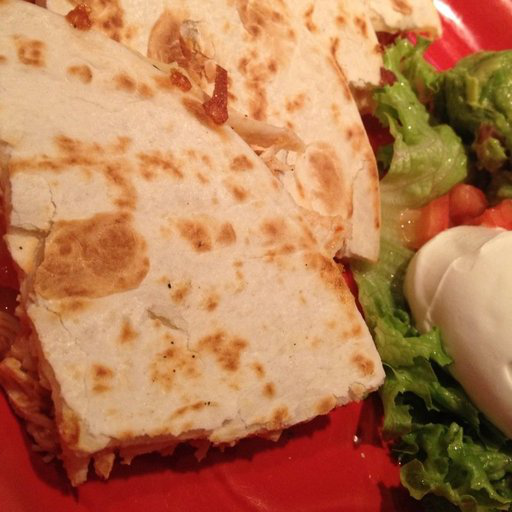

In [ ]:
from PIL import Image
img = Image.open("test/Bread/0.jpg")
img

## Image Vectorizer 모델 로드

https://huggingface.co/facebook/dino-vits16

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16') #vision transformer 모델사용 
model = ViTModel.from_pretrained('facebook/dino-vits16').to("cuda")

print("Models loaded!")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models loaded!


## 임베딩

In [ ]:
img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
outputs = model(**img_tensor)

embedding = outputs.pooler_output.detach().cpu().numpy().squeeze() #최종 pooler_output --> embedding vector 1차원 배열로 변환한다.

embedding #384차원 vector

array([ 9.68370438e-01, -9.99697030e-01,  3.77175391e-01,  1.05852969e-01,
       -1.88724771e-01,  2.93012291e-01,  8.55552673e-01, -9.14432645e-01,
       -6.96700931e-01,  7.87749887e-01,  9.73814845e-01, -1.11642681e-01,
       -9.74638224e-01,  7.42893517e-02,  6.13433719e-01, -9.99746382e-01,
        9.98279691e-01, -9.97295201e-01,  9.88251507e-01, -9.30720747e-01,
        9.99464691e-01,  2.48685673e-01, -7.87896037e-01,  9.99922276e-01,
       -9.97652411e-01, -9.62141454e-01,  9.94611382e-01, -5.55302501e-01,
       -8.81366432e-01, -9.50966179e-01,  2.59666502e-01,  9.42718208e-01,
       -9.43713486e-01, -9.93568778e-01,  8.63866329e-01, -9.96235847e-01,
        4.77496654e-01, -9.15615201e-01,  2.38132074e-01,  9.99989569e-01,
        9.61523354e-01, -9.85543489e-01, -9.28990364e-01,  1.78342000e-01,
        9.28086162e-01, -5.22257328e-01, -8.45609546e-01, -7.51937866e-01,
       -9.93729651e-01,  9.62642550e-01,  7.14636922e-01,  8.57294321e-01,
       -7.33209312e-01,  

In [ ]:
embedding.shape

(384,)

## Chroma DB 시작

https://www.trychroma.com

In [ ]:
import chromadb

client = chromadb.Client()

collection = client.create_collection("foods") #foods라는 컬렉션을 만들어줌

## 모든 이미지 벡터화

In [ ]:
from glob import glob

img_list = sorted(glob("test/*/*.jpg"))

len(img_list)

119

## 임베딩을 데이터베이스에 저장

In [ ]:
from tqdm import tqdm

embeddings = []
metadatas = []
ids = []

for i, img_path in enumerate(tqdm(img_list)): #tqdm은 얼마나 오래 걸리는지를 표시하는 시간
    img = Image.open(img_path)
    cls = img_path.split("/")[1]

    img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
    outputs = model(**img_tensor)

    embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()
    embeddings.append(embedding.tolist())

    metadatas.append({
        "url": img_path,
        "name": cls
    })

    ids.append(str(i))

print("Done!")

collection.add(
    embeddings=embeddings,
    metadatas=metadatas,
    ids=ids,
)

100%|██████████| 119/119 [00:02<00:00, 42.67it/s]


Done!


## Test1

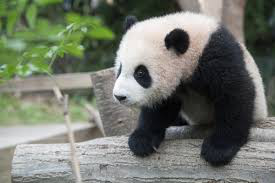

In [ ]:
import requests

# Load the image
test_img = Image.open("/content/test/download.jpg")
#test_img = Image.open(requests.get("https://i.imgur.com/4I0IhII.jpeg", stream=True).raw).convert("RGB")

test_img

In [ ]:
test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
test_outputs = model(**test_img_tensor)

test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze() 

test_embedding=test_embedding.tolist()

In [ ]:
query_result = collection.query(
    query_embeddings=test_embedding,
    n_results=3,
)

query_result

{'ids': [['111', '110', '117']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'url': 'test/panda/p10.jpg', 'name': 'panda'},
   {'url': 'test/panda/p1.jpg', 'name': 'panda'},
   {'url': 'test/panda/p8.jpg', 'name': 'panda'}]],
 'distances': [[49.4948844909668, 75.4037857055664, 107.81922912597656]]}

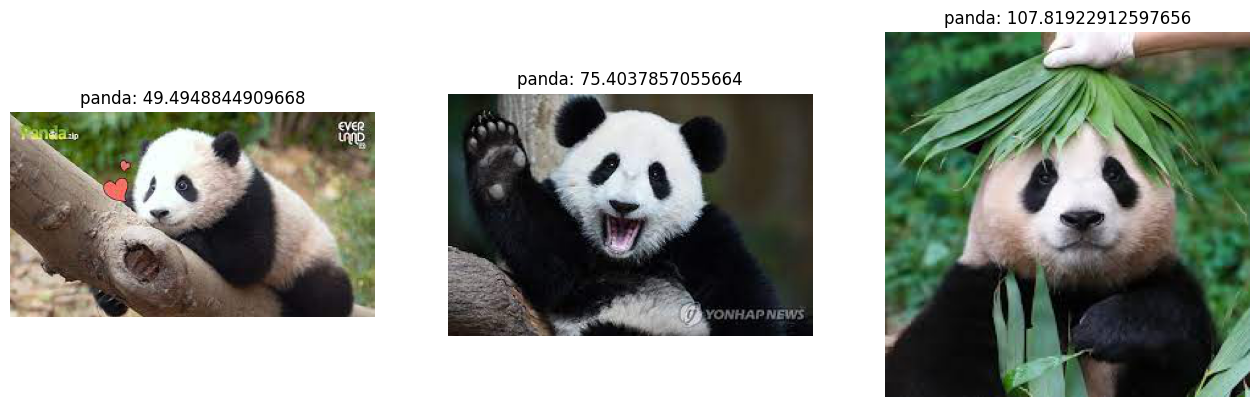

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 10))

for i, metadata in enumerate(query_result["metadatas"][0]):
    distance = query_result["distances"][0][i]

    axes[i].imshow(Image.open(metadata["url"]))
    axes[i].set_title("{}: {}".format(metadata["name"], distance))
    axes[i].axis("off")

## 테스트를 위한 함수화

In [ ]:
def query(img_url, n_results=3):
    #test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
    test_img = Image.open(img_url)
    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
    test_outputs = model(**test_img_tensor)

    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
    test_embedding = test_embedding.tolist()
    query_result = collection.query(
        query_embeddings=[test_embedding],
        n_results=n_results,
    )

    fig, axes = plt.subplots(1, 4, figsize=(16, 10))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]

        axes[i+1].imshow(Image.open(metadata["url"]))
        axes[i+1].set_title("{}: {}".format(metadata["name"], distance))
        axes[i+1].axis("off")

    return query_result

## Test2

{'ids': [['111', '110', '117']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'url': 'test/panda/p10.jpg', 'name': 'panda'},
   {'url': 'test/panda/p1.jpg', 'name': 'panda'},
   {'url': 'test/panda/p8.jpg', 'name': 'panda'}]],
 'distances': [[49.4948844909668, 75.4037857055664, 107.81922912597656]]}

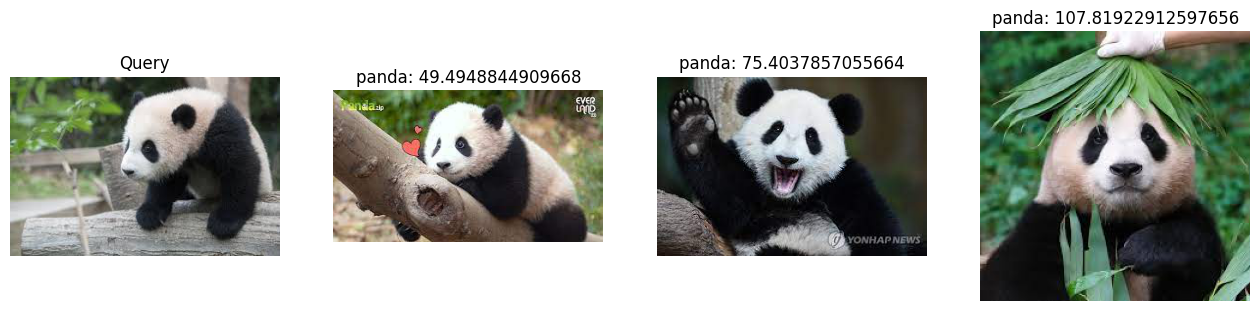

In [ ]:
query("/content/test/download.jpg")